In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util.combine_stream import *
import os

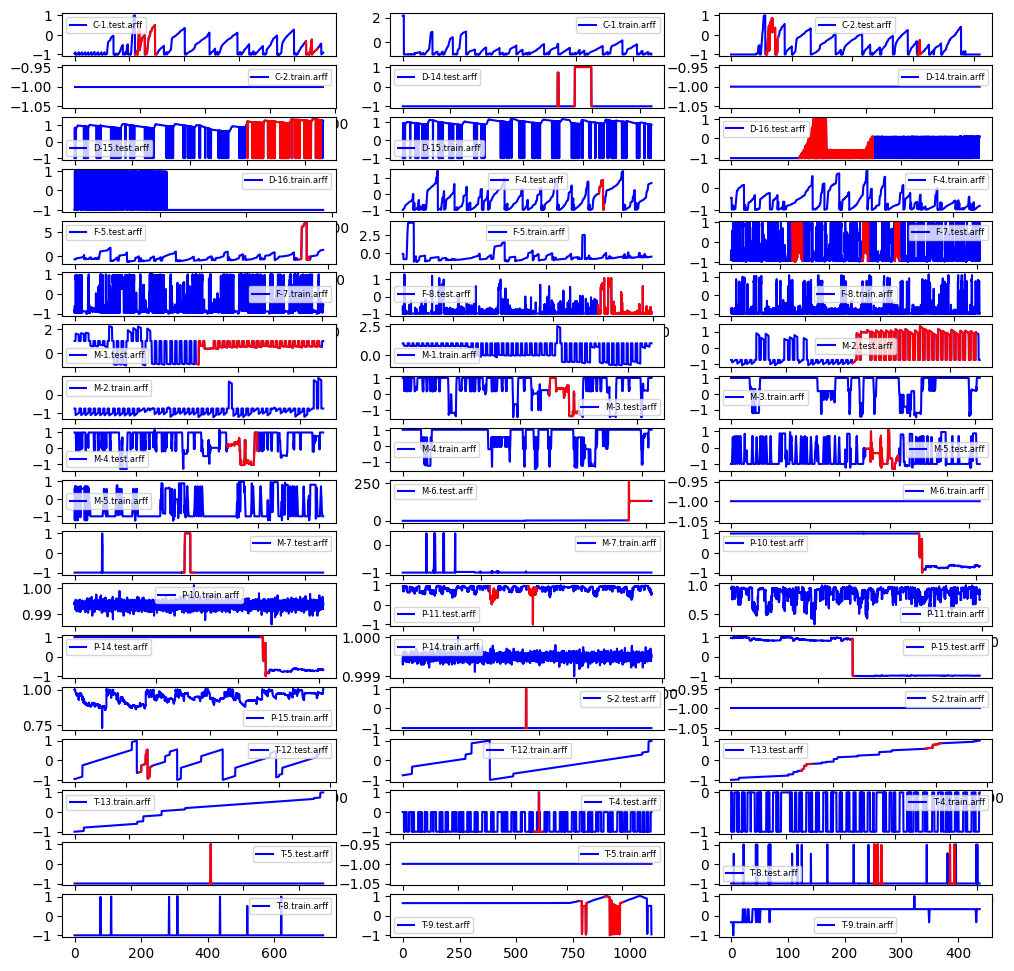

In [2]:
# plotting NASA-MSL
directory = "/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL"
files = os.listdir(directory)
files.sort()
fig, ax = plt.subplots(len(files)//3,3,figsize=(12,12))
for i in range(len(files)):
    X, y = get_arff_data_labels(os.path.join(directory, files[i]))
    anomalous = np.multiply(np.reshape(y,(y.shape[0],1)),X)
    ax[i//3][i%3].plot(np.arange(0,X.shape[0]), X, color="blue", label=files[i])
    ax[i//3][i%3].plot(np.arange(0,X.shape[0]), np.where(anomalous!=0, anomalous, None), color="red")
    ax[i//3][i%3].legend(fontsize="6")

In [2]:
MOA_FILEPATH = '~/Desktop/3H03/moa-release-2023.04.0/lib'

In [3]:
file1 = '/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff'
file2 = '/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff'

In [4]:
X1, y1 = get_arff_data_labels(file1)
X2, y2 = get_arff_data_labels(file2)

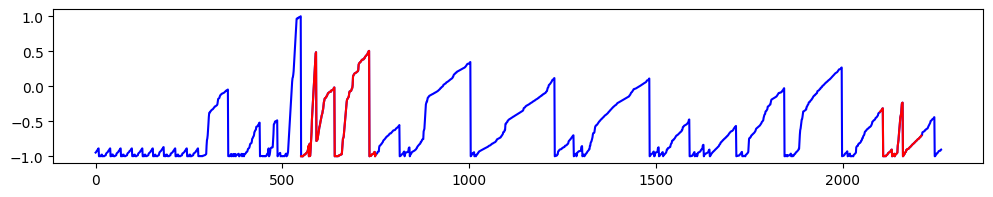

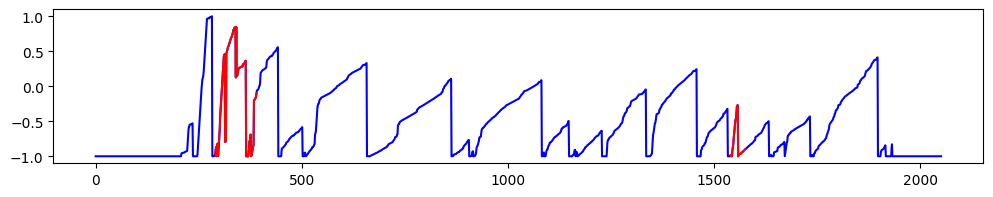

In [5]:
plot_anomaly(X1, y1)
plot_anomaly(X2, y2)

In [6]:
y1_anomalies = find_anomaly_intervals(y1)
y1_anomalies

[[550, 751], [2100, 2211]]

## Drift Generation
For both abrupt and gradual drift, there will be 4 cases of drift which are generated, which are determined based on where the second stream is introduced relative to the latest anomaly on the first stream:

1. Before anomaly (overlapping)
2. Before anomaly (with buffer)
3. After anomaly (with buffer)
4. During anomaly (preserved anomaly)

### Gradual - Before anomaly (overlapping)

Drift will be generated in this case by overlapping the position of the second stream with the start of the last anomaly interval of the first stream. The width of the drift will be twice the width of the anomaly (arbitrarily chosen).

In [7]:
position = y1_anomalies[-1][0]
width = 2 * (y1_anomalies[-1][1] - y1_anomalies[-1][0])
length = y1_anomalies[-1][0] + y2.shape[0]
output_filename = f'C_1_2.test_grad_before_overlap.arff'
output_path = f'/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/{output_filename}'
run_moa = generate_moa_gradual(MOA_FILEPATH, file1, file2, position, width, length, output_path)
run_moa

'!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 2100 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_overlap.arff -m 4151"'

In [8]:
!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 2100 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_overlap.arff -m 4151"


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.13s (CPU time)

Stream written to ARFF file /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_overlap.arff


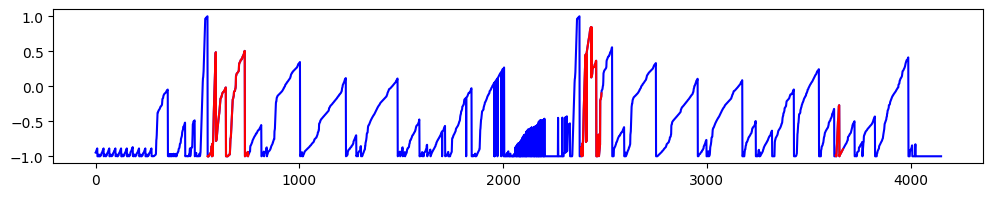

In [9]:
X_drift, y_drift = get_arff_data_labels(output_path)
plot_anomaly(X_drift, y_drift)

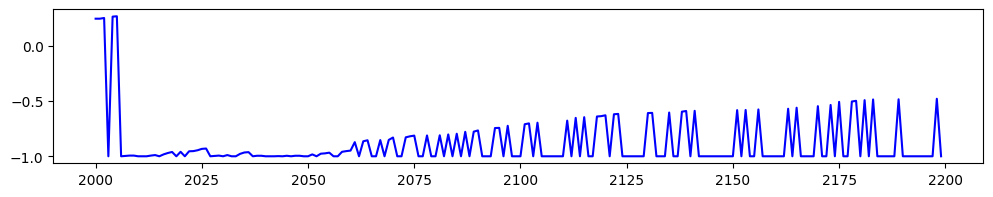

In [11]:
plot_anomaly(X_drift, y_drift, y1_anomalies[-1][0]-100, y1_anomalies[-1][0]+100)

### Gradual - Before anomaly (with buffer)

Drift will be generated in this case by overlapping the position of the second stream before the start of the last anomaly interval of the first stream. The specific index of the second stream will be the [starting index of the anomaly] - [width of the anomaly] (arbitrarily chosen). The width of the drift will be twice the width of the anomaly (arbitrarily chosen).

In [14]:
position = y1_anomalies[-1][0] - (y1_anomalies[-1][1] - y1_anomalies[-1][0])
width = 2 * (y1_anomalies[-1][1] - y1_anomalies[-1][0])
length = y1_anomalies[-1][0] + y2.shape[0]
output_filename = f'C_1_2.test_grad_before_buffer.arff'
output_path = f'/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/{output_filename}'
run_moa = generate_moa_gradual(MOA_FILEPATH, file1, file2, position, width, length, output_path)
print(run_moa)

!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 1989 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_buffer.arff -m 4151"


In [15]:
!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 1989 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_buffer.arff -m 4151"


{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.12s (CPU time)

Stream written to ARFF file /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_before_buffer.arff


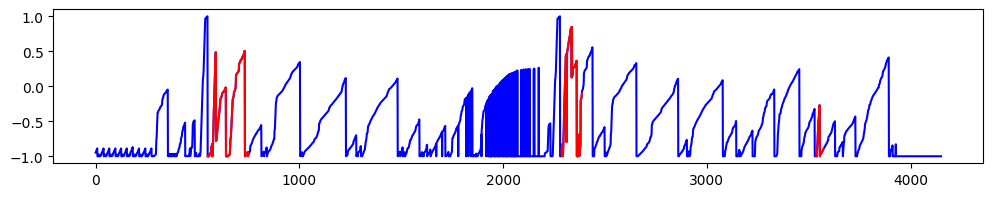

In [16]:
X_drift, y_drift = get_arff_data_labels(output_path)
plot_anomaly(X_drift, y_drift)

### Gradual - After anomaly (with buffer)

Drift will be generated in this case by positioning the second stream after the end of the last anomaly interval of the first stream. The width of the drift will be twice the width of the anomaly (arbitrarily chosen).

In [17]:
position = y1_anomalies[-1][0] + (y1_anomalies[-1][1] - y1_anomalies[-1][0])
width = 2 * (y1_anomalies[-1][1] - y1_anomalies[-1][0])
length = y1_anomalies[-1][0] + y2.shape[0]
output_filename = f'C_1_2.test_grad_after_buffer.arff'
output_path = f'/Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/{output_filename}'
run_moa = generate_moa_gradual(MOA_FILEPATH, file1, file2, position, width, length, output_path)
print(run_moa)

!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 2211 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_after_buffer.arff -m 4151"


In [18]:
!cd ~/Desktop/3H03/moa-release-2023.04.0/lib && java -cp moa.jar -javaagent:sizeofag-1.0.4.jar moa.DoTask "WriteStreamToARFFFile  -s (ConceptDriftStream -s (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-1.test.arff -c 0) -d (ArffFileStream -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/benchmark/NASA-MSL/C-2.test.arff -c 0) -p 2211 -w 222) -f /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_after_buffer.arff -m 4151"



{M}assive {O}nline {A}nalysis
Version:  23.04 April 2023
Copyright: (C) 2007-2023 University of Waikato, Hamilton, New Zealand
Web: http://moa.cms.waikato.ac.nz/

                                                                               
Task completed in 0.12s (CPU time)

Stream written to ARFF file /Users/tammyz/Desktop/3H03/AnomalyDriftDetection/data/synthetic/NASA-MSL/gradual/C_1_2.test_grad_after_buffer.arff


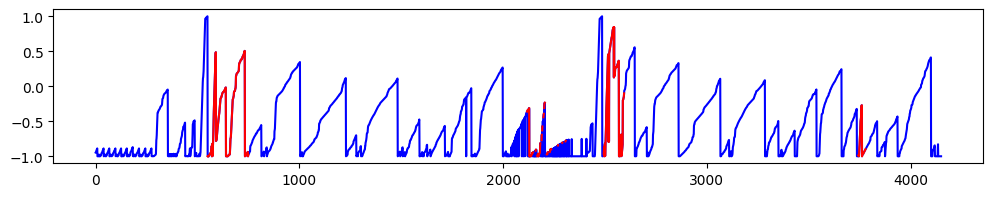

In [19]:
X_drift, y_drift = get_arff_data_labels(output_path)
plot_anomaly(X_drift, y_drift)